# An approach to computing wind risk using HAZUS
- Approach 1: compute damage probability at the building level and finally average damages at keymap square level.

## Read fragility curves from HAZUS
Fragility curves are indexed by
- floors (WSF1 or WSF2)
- roof (hip or gable)
- garage (attached, detached, none)
- shutters (shutters or no shutters) [for Houston it is noshutters]
- terrain (1 though 5)
- damage level (1 through 6)
- wind speed (50 to 250 mph)

Averaged fragility curves are indexed by (averaged over roof and garage)
- floors (WSF1 or WSF2)
- terrain (1 though 5)
- damage level (1 through 6)
- wind speed (50 to 250 mph)



In [9]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# huListofWindBldgTypes.txt is obtained from HAZUS-MH3 source files
# huDamLossFun_Fit.txt is obtained from HAZUS-MH3 source files

# This function reads the raw fragility curve data from HAZUS-MH3 source files and
# constructs a data frame with the following structure
#
# [u'wbID', u'Floors', u'charDescription', u'Roof', u'Shutters', u'Garage',
#       u'TERRAINID', u'DamLossDescID', u'WS50', u'WS55', u'WS60', u'WS65',
#       u'WS70', u'WS75', u'WS80', u'WS85', u'WS90', u'WS95', u'WS100',
#       u'WS105', u'WS110', u'WS115', u'WS120', u'WS125', u'WS130', u'WS135',
#       u'WS140', u'WS145', u'WS150', u'WS155', u'WS160', u'WS165', u'WS170',
#       u'WS175', u'WS180', u'WS185', u'WS190', u'WS195', u'WS200', u'WS205',
#       u'WS210', u'WS215', u'WS220', u'WS225', u'WS230', u'WS235', u'WS240',
#      u'WS245', u'WS250', u'mu', u'sigma']
# For Floors in WSF1, WSF2; Roof in hip, gable, Shutters in shutters, noshutters,
# for Garage in attached, detached, none, for TerrainID in 1-5, for DamLossDescID in 1-6,
# probability of damage due to winds from 50 mph to 250 mph is provided along with
# a mu and sigma for the fitted log normal distribution.

def read_fragility_data():
#     bldg_types = pd.read_csv('FragilityCurves/huListofWindBldgTypes.txt')
    bldg_types = pd.read_csv('/home/isaac/Desktop/storm_damage_prediction/data/FragilityCurves/huListOfWindBldgTypes.txt')


    # extract data for 1 floor and 2 floor building data only
    bldgs1 = bldg_types[((bldg_types["sbtName"]=="WSF1") | (bldg_types["sbtName"]=="WSF2"))]
    # extract data for 6in roof nails, toe nail, and no roof straps
    bldgs1 = bldgs1[(bldgs1["charDescription"].str.contains("rda6d")) & 
                    (bldgs1["charDescription"].str.contains("tnail")) &
                    (bldgs1["charDescription"].str.contains("swrno"))]

    # rename column sbtName to be floors (WSF1 and WSF2)
    bldgs2 = bldgs1[["wbID","sbtName","charDescription"]].copy()
    bldgs2 = bldgs2.rename(columns = {'sbtName':'Floors'})
    
    # add the Roof column: hip or gable
    bldgs2['Roof'] = None
    bldgs2.loc[bldgs2['charDescription'].str.contains('rship'),['Roof']] = 'hip'
    bldgs2.loc[bldgs2['charDescription'].str.contains('rsgab'),['Roof']] = 'gable'

    # add the Shutters column: shutters or noshutters
    bldgs2['Shutters'] = None
    bldgs2.loc[bldgs2['charDescription'].str.contains('shtys'),['Shutters']] = 'shutters'
    bldgs2.loc[bldgs2['charDescription'].str.contains('shtno'),['Shutters']] = 'noshutters'

    # add the Garage column: attached, detached, none
    bldgs2['Garage'] = None
    bldgs2.loc[bldgs2['charDescription'].str.contains('gdstd'),['Garage']] = 'attached'
    bldgs2.loc[bldgs2['charDescription'].str.contains('gdsup'),['Garage']] = 'attached'
    bldgs2.loc[bldgs2['charDescription'].str.contains('gdwkd'),['Garage']] = 'detached'
    # bldgs2.loc[bldgs2['charDescription'].str.contains('gdno'),['Garage']] = 'none'
    bldgs2.loc[bldgs2['charDescription'].str.contains('gdno'),['Garage']] = 'none'

    # populate the fragility statistics
#     fragility1 = pd.read_csv('FragilityCurves/huDamLossFun_Fit.txt')
    fragility1 = pd.read_csv('./data/FragilityCurves/huDamLossFun_Fit.txt')

    fragility = pd.merge(bldgs2,fragility1,on="wbID",how="inner")

    return fragility

# average the fragility curves over roof and garage:
# now fragility curves are indexed by damage state, terrain and floors

def average_fragility(fragility):
    fragility_noshutters = fragility[fragility['Shutters']=='noshutters'].copy()
    wlist = ['WS' + str(i) for i in range(50,255,5)]
    avg_fragility = {}

    grps = fragility_noshutters.groupby(['DamLossDescID','TERRAINID','Floors','Garage','Roof'])
    factors = {('attached','hip'): 0.5 * 0.34, ('attached','gable'): 0.5 * 0.66, ('detached','hip'): 0.25 * 0.34,
                  ('detached','gable'): 0.25 * 0.66,('none','hip'): 0.25 * 0.34,
                  ('none','gable'): 0.25 * 0.66}
    for dam_state  in range(1,5):
        for terrain in range(1,5):
            for floors in ['WSF1','WSF2']:
                g1 = pd.DataFrame()  
                for garage in ['attached','detached','none']:
                    for roof in ['hip','gable']:
                        g = grps.get_group((dam_state,terrain,floors,garage,roof))
                        x = g[wlist].mean(axis=0) * factors[(garage,roof)]
                        g1 = g1.append(x,ignore_index=True)
                
    
                avg_fragility[(dam_state,terrain,floors)] = g1.sum(axis=0)                                                          

    avg_frag = pd.DataFrame.from_items([(avg_fragility.keys()[k],avg_fragility.values()[k]) for k in range(len(avg_fragility))])
    avg_frag = avg_frag.transpose()
    avg_frag['Floors'] = [t[2] for t in avg_frag.index]
    avg_frag['DamLossDescID'] = [t[0] for t in avg_frag.index]
    avg_frag['TERRAINID'] = [t[1] for t in avg_frag.index]
    return avg_frag

## Read building level data (df_meta and data.p; shared with Isaac)

In [2]:
# df_meta: meta data
# check the pickled data.p and df_meta.p from may2015 directory

def read_dfs():
#     df_meta = pd.read_csv('../../code/new_wind_model/may2015/df_meta.csv')
    df_meta = pd.read_csv('./data/df_meta.csv')

    df_meta.drop(df_meta.columns[0],1,inplace=True)
    print "df_meta shape: ", df_meta.shape

    # read the pickled data file data.p

#     df_data = pd.read_pickle('../../code/new_wind_model/may2015/data.p')
    df_data = pd.read_pickle('./data/data.p')

    df_data = pd.DataFrame(df_data).transpose()
    df_data['hcad'] = df_data.index
    return df_meta, df_data

### Extract number of floors and wind data from df_data
- extract number of floors, max wind, low_wind, high_wind (rounding of maxwind in mutliples of 5)

In [3]:
def extract_bld_wind(df_data,factor):
    wlist = ['spd' + str(i) for i in range(1,12)]
    bld_wind_data = df_data[['hcad','bld_ar']+wlist].copy()
    bld_wind_data['Floors'] = 'WSF1'
    bld_wind_data.loc[bld_wind_data['bld_ar'] > 1800,'Floors'] = 'WSF2'
    bld_wind_data = bld_wind_data[['hcad','Floors'] + wlist]

    # add the MaxWind field
    bld_wind_data['MaxWind'] = bld_wind_data[['spd1','spd2','spd3','spd4','spd5','spd6','spd7','spd8','spd9','spd10','spd11',]].apply(max,axis=1)
    bld_wind_data['MaxWind'] = bld_wind_data['MaxWind'].apply(lambda x: x * 2.237 * factor)  # convert from meters/sec to miles/hr
    bld_wind_data = bld_wind_data[['hcad','Floors','MaxWind']]

    # put the bounding speeds on (rounded to 50s) based on MaxWind

    w = bld_wind_data['MaxWind'] 
    bld_wind_data['low_wind'] = 50 + np.floor((w-50)/5.0) * 5
    bld_wind_data['low_wind'] = bld_wind_data['low_wind'].astype(int)
    bld_wind_data['high_wind'] = 50 + np.ceil((w-50)/5.0) * 5
    bld_wind_data['high_wind'] = bld_wind_data['high_wind'].astype(int)
    print "bld_wind data shape: ", bld_wind_data.shape
    return bld_wind_data

### Extract terrain (use Isaac's terrain info)

In [4]:
# terrain data (Isaac)
def extract_terrain(bld_wind_data):
#     terrain = pd.read_csv('hcad_land_cover.txt')
    terrain = pd.read_csv('./data/hcad_land_cover.txt')
    
    terrain = terrain.rename(columns={'HCAD_NUM':'hcad'})

# Terrain coding
# 1 = developed high intensity
# 2 = developed low intensity
# 3 = developed open space
# 4  =  cultivated
# 5  =  grassland/shrub
# 6  =  forest
# 7  =  woody wetland
# 8 =  herbaceous wetland
# 9 =  barren
# 10 = water

    # Translation table from HAZUS Technical Manual (Table 3.9; Texas values)
    roughness_map = {1:0.55, 2:0.35, 3:0.44, 4:0.05, 5:0.07, 6:0.55, 7:0.50, 8: 0.10, 9:0.13, 10: 0.011}

# In HAZUS: we have terrainid 1-5 mapped according to
# 0 - 0.03 = 1
# 0.03 - 0.15 = 2
# 0.15 - 0.35 = 3
# 0.35 - 0.7 = 4
# 0.7 - 1.00 = 5 

#rterrain_map = pd.DataFrame({1:4, 2:3, 3:4, 4:2, 5:2, 6:4, 7:4, 8: 2, 9:2, 10: 1}.items())
    rterrain_map = pd.DataFrame({1:4, 2:4, 3:4, 4:2, 5:2, 6:4, 7:4, 8: 2, 9:3, 10: 1}.items())
    rterrain_map.columns = ['LAND_COVER','TERRAINID']


    # Map each roughness value to fragility curve terrain model
    # map to roughness scale in HAZUS (HAZUS has roughness length)

    terrain.groupby(['LAND_COVER']).count()
    rterrain = pd.merge(terrain,rterrain_map,on=['LAND_COVER'],how='inner')
    rterrain = rterrain[['hcad','TERRAINID']]

    # merge building, wind and terrain data
    hazus_data = pd.merge(rterrain,bld_wind_data,on=['hcad'],how='inner')
    # print hazus_data.shape, hazus_data.columns
    return hazus_data

## Compute individual home level probability of damage
- use averaged fragility curves to estimate probability of damage for each home from number of floors, maxwind (low wind, high wind), also include actual damage information for each home from Ragland damage data.

In [5]:
import sklearn
from sklearn import metrics

# merge average fragility curves with the hazus_data
def compute_hazus_prob(hazus_data, df_meta, avg_frag):
    
    hazus_data1 = pd.merge(hazus_data,avg_frag,on=['Floors','TERRAINID'], how='inner')
    hazus_data2 = hazus_data1[(hazus_data1['DamLossDescID']==1) | (hazus_data1['DamLossDescID']==2)]
    hazus_data2 = hazus_data2.reset_index()

    # calculate probability associated with lower wind speed (rounded to the 50-250 in steps of 5)

    low_probs = np.zeros((hazus_data2.shape[0],))
    for speed in range(50,255,5):
        low_probs[hazus_data2[hazus_data2['low_wind']==speed].index.tolist()]= hazus_data2.loc[hazus_data2['low_wind']==speed,'WS'+str(speed)]
    hazus_data2.loc[:,'low_prob'] = pd.Series(low_probs,index=hazus_data2.index)

    # calculate probability associated with higher wind speed (rounded to the 55-90 in steps of 5)

    high_probs = np.zeros((hazus_data2.shape[0],))
    for speed in range(55,255,5):
        high_probs[hazus_data2[hazus_data2['high_wind']==speed].index.tolist()]= hazus_data2.loc[hazus_data2['high_wind']==speed,'WS'+str(speed)]
    hazus_data2.loc[:,'high_prob'] = pd.Series(high_probs,index=hazus_data2.index)

    ptable = hazus_data2[['hcad','Floors','TERRAINID','DamLossDescID','MaxWind','low_wind','high_wind','low_prob','high_prob']].copy()

    # linear interpolation between low prob and high prob

    ptable['factor'] = ((ptable['high_prob']-ptable['low_prob'])/(ptable['high_wind']-ptable['low_wind'])) 
    ptable['dprob'] = ptable['low_prob'] + ptable['factor'] * (ptable['MaxWind']-ptable['low_wind'])

    # merge keymap information

    ptable = pd.merge(ptable,df_meta[['hcad','keymap']],on=['hcad'],how='inner')

    # merge with damage information 
#     pdamage = pd.read_csv('../new_wind_model/may2015/pdamage.csv')
    pdamage = pd.read_csv('./data/pdamage.csv')
    
    pdamage.drop(pdamage.columns[0],1,inplace=True)
    pdamage = pdamage[['hcad','damage']]
    ptable1 = pd.merge(pdamage,ptable,on=["hcad"],how="inner")

    # probability of damage = prob of ds1 - prob of ds2

    s1 = ptable1[ptable1['DamLossDescID']==1][['hcad','dprob','keymap','damage']]
    s2 = ptable1[ptable1['DamLossDescID']==2][['hcad','dprob','keymap','damage']]
    results = pd.merge(s1,s2,on=["hcad","keymap","damage"],how="inner")
    results['dprob1'] = results['dprob_x'] - results['dprob_y']
    print metrics.roc_auc_score(results.damage, results.dprob1, average='macro', sample_weight=None)
    return results

def agg_prob_keymap(results):
    # aggregate results by keymap square
    pcounts = results.groupby('keymap').agg({'dprob1':'sum','damage': {'damage_sum':'sum','total':'count'}})
    return pcounts

# Compute probability at home level and then aggregate

In [6]:
# run the protocol at the building level, then aggregate to keymap

def run_approach1():
    fragility = read_fragility_data()
    df_meta, df_data = read_dfs()
    avg_frag = average_fragility(fragility)

    factor = 0.9
    
    
    results09 = compute_hazus_prob(hazus_data, df_meta, avg_frag)
    pcounts09 = agg_prob_keymap(results09)

    factor = 1.0
    bld_wind_data = extract_bld_wind(df_data,factor)
    hazus_data = extract_terrain(bld_wind_data)
    results10 = compute_hazus_prob(hazus_data, df_meta, avg_frag)
    pcounts10 = agg_prob_keymap(results10)

    factor = 1.1
    bld_wind_data = extract_bld_wind(df_data,factor)
    hazus_data = extract_terrain(bld_wind_data)
    results11 = compute_hazus_prob(hazus_data, df_meta, avg_frag)
    pcounts11 = agg_prob_keymap(results11)

    # is actual damage between pcounts09 and pcounts11
    r = pd.DataFrame()
    r['0.9'] = pcounts09['dprob1']['sum']
    r['1.1'] = pcounts11['dprob1']['sum']
    r['1.0'] = pcounts10['dprob1']['sum']
    r['actual'] = pcounts09['damage']['damage_sum']
    r['total'] = pcounts09['damage']['total']

    # is actual damage between pcounts09 and pcounts11?
    print "Raw count analysis"
    print "Correct: ", r[(r['0.9'] <= r['actual']) & (r['1.1'] >= r['actual'])].shape
    print "Over: ", r[r['0.9'] > r['actual']].shape
    print "Under:", r[r['1.1'] < r['actual']].shape

    # take ratios into account in the comparison
    ratios = pd.DataFrame()
    ratios['0.9'] = pcounts09['dprob1']['sum']/pcounts09['damage']['total']
    ratios['1.1'] = pcounts11['dprob1']['sum']/pcounts09['damage']['total']
    ratios['1.0'] = pcounts10['dprob1']['sum']/pcounts09['damage']['total']
    ratios['actual'] = pcounts09['damage']['damage_sum']/pcounts09['damage']['total']
    ratios['keymap'] = ratios.index
    
    # correct if in interval or within 0.1 of the interval edge
    print "Ratio analysis"
    threshold = 0.1
    print "Correct: ", ratios[((ratios['0.9']-threshold) <= ratios['actual']) 
                          & ((ratios['1.1']+threshold) >= ratios['actual'])].shape
    print "Over: ", ratios[(ratios['0.9']-threshold) > ratios['actual']].shape
    print "Under:", ratios[(ratios['1.1']+threshold) < ratios['actual']].shape

    return ratios

In [7]:
# correct if in interval or within 0.1 of the interval edge
def test_threshold():
    for threshold in [0,0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]:
        print "Ratio analysis", threshold
        print "Correct: ", r1[((r1['0.9']-threshold) <= r1['actual']) & ((r1['1.1']+threshold) >= r1['actual'])].shape
        print "Over: ", r1[(r1['0.9']-threshold) > r1['actual']].shape
        print "Under:", r1[(r1['1.1']+threshold) < r1['actual']].shape

## Visualize the results

In [10]:
# draw the shape files for keymaps in Harris county
import geopandas as gpd
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # 

# read the shapefile as a GeoDataFrame
# harris = gpd.GeoDataFrame.from_file("../new_wind_model/otherSHPs/keymap_harris.shp")
harris = gpd.GeoDataFrame.from_file("./data/keymap_harris.shp")

damage_probs = run_approach1()

# merge harris with damage_probs
harris1 = pd.merge(damage_probs,harris,left_on='keymap', right_on='PageSq',how='inner')
geo_harris1 = gpd.GeoDataFrame(harris1,geometry=harris1.geometry)
geo_harris1.plot(column='1.1',cmap='jet',scheme='fisher_jenks',legend=True)


df_meta shape:  (870476, 8)


TypeError: The numpy boolean negative, the `-` operator, is not supported, use the `~` operator or the logical_not function instead.

df_meta shape:  (870476, 8)
bld_wind data shape:  (870476, 5)
0.434802788692
bld_wind data shape:  (870476, 5)
0.435275594428
bld_wind data shape:  (870476, 5)
0.435756936079
Raw count analysis
Correct:  (142, 5)
Over:  (238, 5)
Under: (1886, 5)
Ratio analysis
Correct:  (1031, 5)
Over:  (0, 5)
Under: (1235, 5)


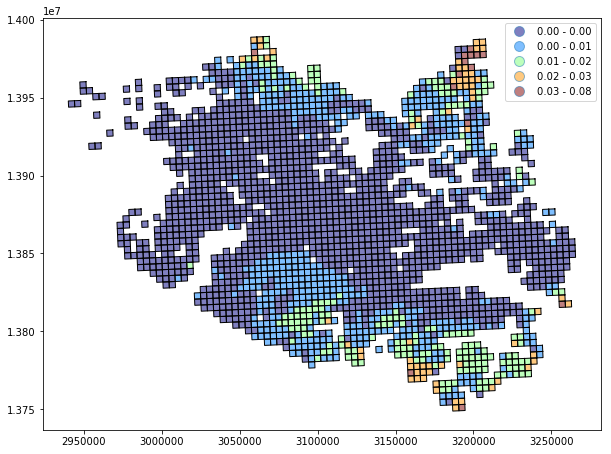

In [230]:
# draw the shape files for keymaps in Harris county
import geopandas as gpd
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # 

# read the shapefile as a GeoDataFrame
# harris = gpd.GeoDataFrame.from_file("../new_wind_model/otherSHPs/keymap_harris.shp")
harris = gpd.GeoDataFrame.from_file("./data/keymap_harris.shp")

damage_probs = run_approach1()

# merge harris with damage_probs
harris1 = pd.merge(damage_probs,harris,left_on='keymap', right_on='PageSq',how='inner')
geo_harris1 = gpd.GeoDataFrame(harris1,geometry=harris1.geometry)
geo_harris1.plot(column='1.1',cmap='jet',scheme='fisher_jenks',legend=True)


## The actual damage probabilities

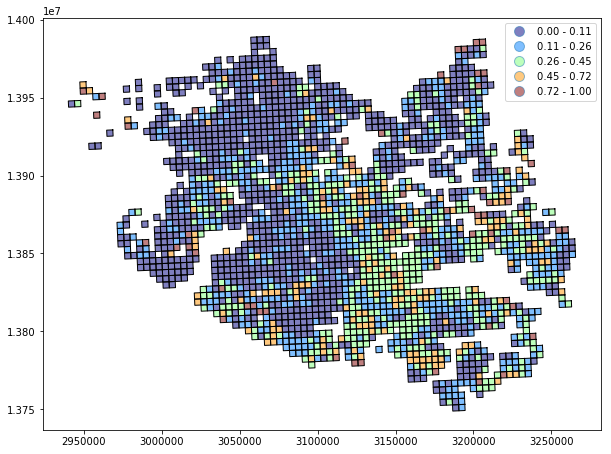

In [228]:
geo_harris1.plot(column='actual',cmap='jet',scheme='fisher_jenks',legend=True)